In [6]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from matplotlib import pyplot


warnings.filterwarnings("ignore")

In [4]:
os.getcwd()
print(os.listdir())

['.ipynb_checkpoints', 'clip_0000adecb.wav', 'finalized_model.sav', 'link_to_gcp_credits_form.txt', 'sample_submission', 'sample_submission.7z', 'test', 'train', 'Untitled CNN.ipynb', 'Untitled.ipynb', 'Untitled1.ipynb', 'Untitled2.ipynb', 'Untitled3.ipynb', 'Untitled4.ipynb']


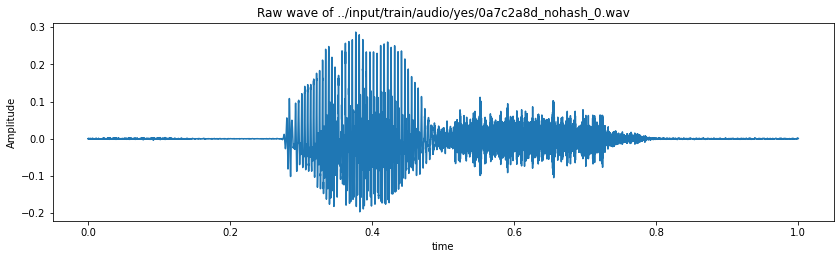

In [5]:
train_audio_path = 'train/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../input/train/audio/yes/0a7c2a8d_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

In [13]:
ipd.Audio(samples, rate=sample_rate)


In [14]:
print(sample_rate)


16000


In [15]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [16]:
labels=os.listdir(train_audio_path)


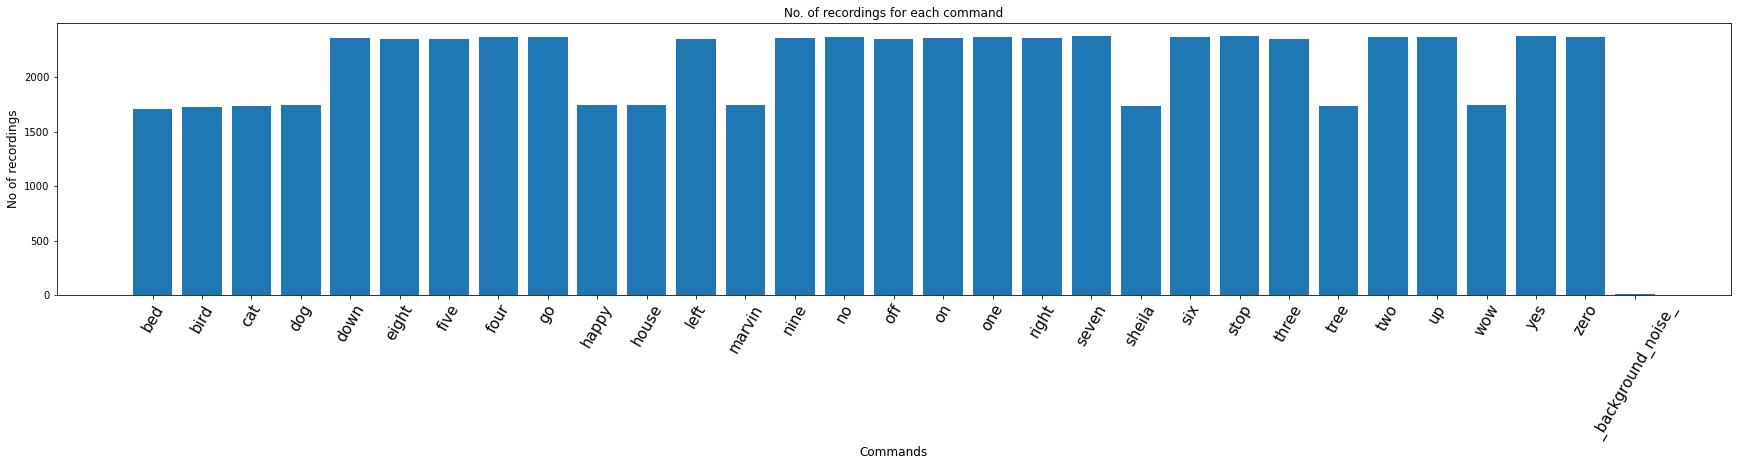

In [17]:
#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [18]:
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]


(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

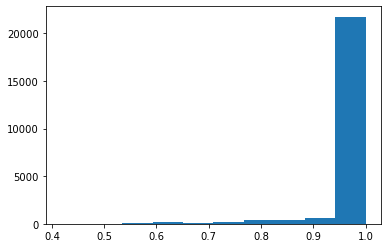

In [19]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [20]:
train_audio_path = 'train/train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [21]:

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [22]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))


In [23]:
all_wave = np.array(all_wave).reshape(-1,8000,1)


In [24]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [25]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)          

In [28]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [30]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))


Epoch 1/100
533/533 [==============================] - 118s 222ms/step - loss: 2.0528 - accuracy: 0.2261 - val_loss: 1.6533 - val_accuracy: 0.4164
Epoch 2/100
533/533 [==============================] - 117s 220ms/step - loss: 1.3788 - accuracy: 0.4970 - val_loss: 1.0223 - val_accuracy: 0.6620
Epoch 3/100
533/533 [==============================] - 118s 221ms/step - loss: 1.0797 - accuracy: 0.6169 - val_loss: 0.8908 - val_accuracy: 0.6939
Epoch 4/100
533/533 [==============================] - 118s 222ms/step - loss: 0.9290 - accuracy: 0.6746 - val_loss: 0.7704 - val_accuracy: 0.7455
Epoch 5/100
533/533 [==============================] - 117s 220ms/step - loss: 0.8320 - accuracy: 0.7075 - val_loss: 0.7144 - val_accuracy: 0.7678
Epoch 6/100
533/533 [==============================] - 117s 220ms/step - loss: 0.7649 - accuracy: 0.7318 - val_loss: 0.6674 - val_accuracy: 0.7748
Epoch 7/100
533/533 [==============================] - 116s 219ms/step - loss: 0.7088 - accuracy: 0.7569 - val_loss: 0

In [32]:
from keras.models import load_model
model=
('best_model.hdf5')

OSError: SavedModel file does not exist at: best_model.hdf5/{saved_model.pbtxt|saved_model.pb}

In [33]:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [51]:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: on


In [52]:
print("Text:",predict(samples))


Text: on


In [1]:
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

NameError: name 'random' is not defined

In [37]:
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: right


In [38]:
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: go


In [56]:
print("Text:",predict(samples))


Text: yes


In [57]:
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: stop


In [59]:
print("Text:",predict(samples))


Text: stop


In [46]:
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: off


In [47]:
print("Text:",predict(samples))


Text: off


In [49]:
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio: right


In [50]:
print("Text:",predict(samples))


Text: right


In [48]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

ModuleNotFoundError: No module named 'sounddevice'

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [33]:
# Import Required packages 
#-------------------------

# Import the Logistic Regression Module from Scikit Learn
from sklearn.linear_model import LogisticRegression  

# Import the IRIS Dataset to be used in this Kernel
from sklearn.datasets import load_iris  

# Load the Module to split the Dataset into Train & Test 
from sklearn.model_selection import train_test_split

In [32]:
# save the model to disk

filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

TypeError: cannot pickle '_thread.RLock' object

In [34]:
Iris_data = load_iris()  


In [35]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Iris_data.data, 
                                                Iris_data.target, 
                                                test_size=0.3, 
                                                random_state=4)

In [28]:
from keras.models import load_model


In [29]:
model=load_model('best_model.hdf5')

OSError: SavedModel file does not exist at: best_model.hdf5/{saved_model.pbtxt|saved_model.pb}